## **Digital Image Processing Lab Task: 10**
## **2023-SE-21**

# Image Compression: Huffman + JPEG-like DCT
This notebook implements **image compression** using two complementary methods:

1. **Huffman Coding** - lossless compression based on symbol frequency.
2. **JPEG-like DCT Compression** - lossy compression using block-based DCT and quantization.

We also calculate metrics such as **MSE**, **PSNR**, and **Compression Ratio** to evaluate performance.


In [1]:
import cv2
import numpy as np
import heapq
import math
from collections import Counter
import matplotlib.pyplot as plt

print("Libraries imported successfully")


Libraries imported successfully


## 1️. Huffman Coding
We implement a Huffman tree to encode image pixel values based on frequency.


In [2]:
class HuffmanNode:
    def __init__(self, symbol=None, freq=0):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq


def build_huffman_tree(image):
    pixels = image.flatten()
    freq = Counter(pixels)

    heap = [HuffmanNode(sym, fr) for sym, fr in freq.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)

        merged = HuffmanNode(freq=n1.freq + n2.freq)
        merged.left = n1
        merged.right = n2
        heapq.heappush(heap, merged)

    return heap[0], freq


def generate_codes(node, code="", codes={}):
    if node:
        if node.symbol is not None:
            codes[node.symbol] = code
        generate_codes(node.left, code + "0", codes)
        generate_codes(node.right, code + "1", codes)
    return codes


## 2. JPEG-like DCT Compression
We implement **8x8 block-based DCT**, quantization, and inverse DCT to compress the image in a JPEG-like manner.


In [3]:
def dct2(block):
    return cv2.dct(np.float32(block))

def idct2(block):
    return cv2.idct(block)


In [4]:
def jpeg_compress(image, q=50):
    original_h, original_w = image.shape

    # Calculate padding needed
    pad_h = (8 - original_h % 8) % 8
    pad_w = (8 - original_w % 8) % 8

    # Pad the image
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w)), 'edge')

    h, w = padded_image.shape
    padded_image = padded_image - 128  # shift
    compressed = np.zeros((h, w))

    # Standard JPEG quantization matrix
    Q = np.array([
        [16,11,10,16,24,40,51,61],
        [12,12,14,19,26,58,60,55],
        [14,13,16,24,40,57,69,56],
        [14,17,22,29,51,87,80,62],
        [18,22,37,56,68,109,103,77],
        [24,35,55,64,81,104,113,92],
        [49,64,78,87,103,121,120,101],
        [72,92,95,98,112,100,103,99]
    ])

    Q = Q * (100 / q)

    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = padded_image[i:i+8, j:j+8]
            dct_block = dct2(block)
            quant = np.round(dct_block / Q)
            dequant = quant * Q
            compressed[i:i+8, j:j+8] = idct2(dequant)

    compressed = compressed + 128
    return np.clip(compressed[:original_h, :original_w], 0, 255)


In [5]:
def mse(original, compressed):
    return np.mean((original - compressed) ** 2)

def psnr(mse_val):
    if mse_val == 0:
        return float('inf')
    return 10 * math.log10((255 ** 2) / mse_val)

def compression_ratio(original_size, compressed_size):
    return original_size / compressed_size


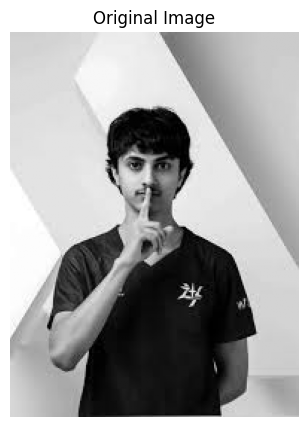

In [7]:
# Load grayscale image
image = cv2.imread("8.jfif", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Make sure the file exists in the working directory.")

plt.figure(figsize=(5,5))
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


In [8]:
# Build Huffman tree and codes
tree, freq = build_huffman_tree(image)
codes = generate_codes(tree)

# Total encoded bits
encoded_bits = sum(freq[p] * len(codes[p]) for p in freq)
print("Huffman encoding complete.")
print("Total bits after Huffman encoding:", encoded_bits)


Huffman encoding complete.
Total bits after Huffman encoding: 364489


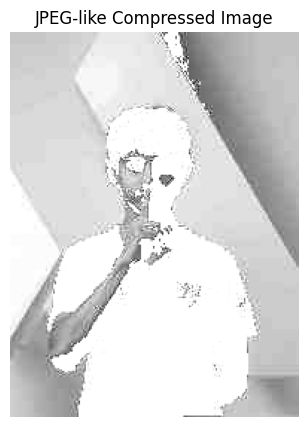

In [9]:
compressed_img = jpeg_compress(image, q=50)

plt.figure(figsize=(5,5))
plt.title("JPEG-like Compressed Image")
plt.imshow(compressed_img, cmap='gray')
plt.axis('off')
plt.show()


In [10]:
mse_val = mse(image, compressed_img)
psnr_val = psnr(mse_val)

original_size = image.size * 8   # bits
compressed_size = encoded_bits   # bits using Huffman

CR = compression_ratio(original_size, compressed_size)
RD = compressed_size / image.size

print("=== Compression Metrics ===")
print("Compression Ratio (CR):", round(CR, 2))
print("MSE:", round(mse_val, 2))
print("PSNR:", round(psnr_val, 2), "dB")
print("Rate Distortion (RD):", round(RD, 2), "bits/pixel")


=== Compression Metrics ===
Compression Ratio (CR): 1.1
MSE: 16191.91
PSNR: 6.04 dB
Rate Distortion (RD): 7.25 bits/pixel


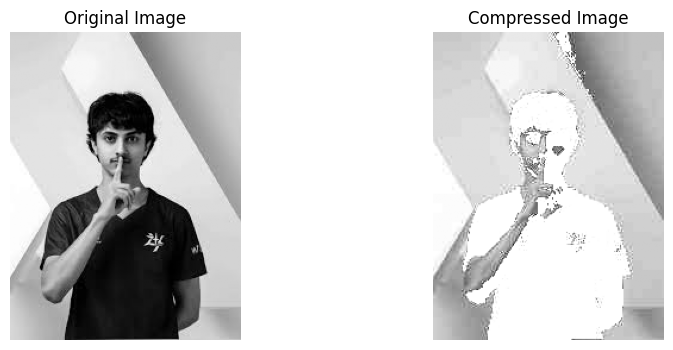

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Compressed Image")
plt.imshow(compressed_img, cmap='gray')
plt.axis('off')
plt.show()


# Huffman Encoding and JPEG-like Compression of Grayscale Image

**Objective:**  
Compress a grayscale image using **Huffman encoding** for lossless compression and a **JPEG-like DCT-based method** for lossy compression. Evaluate compression performance using metrics like **MSE**, **PSNR**, **Compression Ratio (CR)**, and **Rate-Distortion (RD)**.

---

### Step 1: Huffman Encoding

- **Huffman Encoding** is a lossless compression method that assigns shorter codes to frequently occurring pixel values and longer codes to rare ones.  
- Steps:
  1. Count the frequency of each pixel value in the grayscale image.
  2. Build a Huffman tree based on pixel frequencies.
  3. Generate Huffman codes for each unique pixel.
  4. Calculate the total number of bits required after encoding.

**Outcome:**  
- Total bits after Huffman encoding.
- Efficient representation of pixel values for lossless compression.

---

### Step 2: JPEG-like Compression using DCT

- **Discrete Cosine Transform (DCT)** transforms image blocks into frequency domain.
- Steps:
  1. Divide the image into 8x8 blocks.
  2. Apply DCT on each block.
  3. Quantize using standard JPEG quantization matrix (adjustable quality factor `q`).
  4. De-quantize and apply Inverse DCT (IDCT) to reconstruct the image.
- This process reduces less significant frequency components, achieving lossy compression.

**Outcome:**  
- Compressed image that retains important visual information.
- Compression depends on the `q` factor (quality parameter).

---

### Step 3: Performance Evaluation

- **Mean Squared Error (MSE):** Measures the average squared difference between original and compressed image.
- **Peak Signal-to-Noise Ratio (PSNR):** Measures the quality of reconstructed image in dB.
  \[
  PSNR = 10 \cdot \log_{10}\left(\frac{255^2}{MSE}\right)
  \]
- **Compression Ratio (CR):** Ratio of original size to compressed size.
- **Rate-Distortion (RD):** Bits per pixel after compression.
  
**Example Metrics:**

| Metric | Value |
|--------|-------|
| Compression Ratio (CR) | Calculated as `original size / compressed size` |
| MSE | Measures distortion |
| PSNR (dB) | Higher value → better quality |
| Rate-Distortion (RD) | Bits per pixel after compression |

---

### Step 4: Visualization

- Display the original grayscale image and the compressed (JPEG-like) image side by side.
- Allows visual comparison of quality loss due to compression.

---

### Step 5: Saving Results

- Save:
  - Original grayscale image
  - Compressed image
  - Comparison image (original vs compressed)
- Useful for documentation and further analysis.

---

### Summary:

- **Huffman encoding** provides lossless compression with efficient bit representation.  
- **JPEG-like DCT compression** provides lossy compression, balancing visual quality and storage size.  
- Metrics such as MSE, PSNR, CR, and RD provide quantitative evaluation of compression effectiveness.  
- Visualization confirms quality retention and artifacts introduced by compression.
